# Importing libraries

In [1]:
# standard data science library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# Text processing and model building libraries
import random
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.stem.snowball import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

# matplotlib defaults
plt.style.use("seaborn-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movies-reviews-dataset/sentiment_train


# Load and explore a dataset

In [2]:
train_ds = pd.read_csv("/kaggle/input/movies-reviews-dataset/sentiment_train", delimiter="\t")
train_ds.head(10)

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...
5,1,that's not even an exaggeration ) and at midni...
6,1,"I loved the Da Vinci Code, but now I want some..."
7,1,"i thought da vinci code was great, same with k..."
8,1,The Da Vinci Code is actually a good movie...
9,1,I thought the Da Vinci Code was a pretty good ...


In [3]:
train_ds.shape

(6918, 2)

In [4]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6918 entries, 0 to 6917
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  6918 non-null   int64 
 1   text       6918 non-null   object
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [5]:
train_ds.describe(include=['object','int64'])

,sentiment,text
count,6918.000000,6918
unique,NaN,1291
top,NaN,I love Harry Potter.
freq,NaN,167
mean,0.569962,NaN
std,0.495117,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,1.000000,NaN
75%,1.000000,NaN


**Insight:** In our dataset there are 1291 unique reviews and most frquent one is 'I love Harry Potter'. 

In [6]:
# set width of the columns as 800 charactors
pd.set_option('max_colwidth', 800)
train_ds[train_ds.sentiment == 1][:5] # five positive sentiments

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [7]:
# five negative sentiments
train_ds[train_ds.sentiment == 0][:5]

,sentiment,text
3943,0,da vinci code was a terrible movie.
3944,0,"Then again, the Da Vinci code is super shitty movie, and it made like 700 million."
3945,0,"The Da Vinci Code comes out tomorrow, which sucks."
3946,0,i thought the da vinci code movie was really boring.
3947,0,"God, Yahoo Games has this truly-awful looking Da Vinci Code-themed skin on it's chessboard right now."


In [8]:
#  number of reviews per sentiment
sen_df = train_ds['sentiment'].value_counts().reset_index()
sen_df['% of reviews'] = sen_df['sentiment'].map(lambda x : (x/sen_df['sentiment'].sum())*100)
sen_df

,index,sentiment,% of reviews
0,1,3943,56.996242
1,0,2975,43.003758


**Insight:** 

**Approx 60% of reviews are positive while 43% of them are negative ones.**

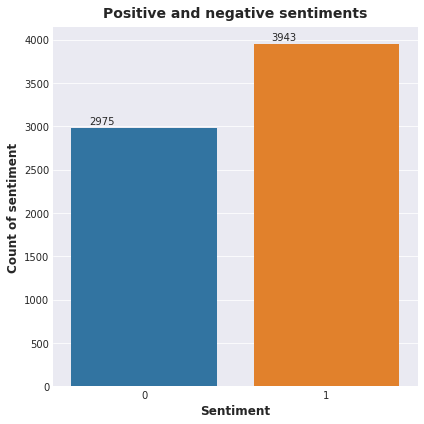

In [9]:
# plot the sentiments using count plot of the seaborn
plt.figure(figsize=(6,6))
ax = sns.countplot(x='sentiment', data=train_ds)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height() + 50))
plt.title("Positive and negative sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count of sentiment")
plt.show()

# Text Pre-processing and vectorization of text data

**BOW (Bag of words model):**

1. Count Vector model
2. Term Frequecny Vector model
3. Term-Frequency-Inverse Document Frequency (TF-IDF) Model

In out dataset, each text line will be called as a document, which will be used as vector to calculate count vecotrizer and TF/TF-IDF vectors.

# 1. Using Count vectorizer

In [10]:
# Initialize the count vectorizer
count_vectorizer = CountVectorizer()
# Create the dictionary from the corpus
feature_vector = count_vectorizer.fit(train_ds.text)
# get the feature names
features0 = feature_vector.get_feature_names()
print("Total number of features: ", len(features0))
print("-----------------------------------------")
# name of the each features
print(feature_vector.get_feature_names_out())
print("-----------------------------------------")
# random feature names
print(random.sample(features0, 10))

Total number of features:  2132
-----------------------------------------
['00' '007' '10' ... 'zach' 'zen' 'µª']
-----------------------------------------
['ate', 'throw', 'tennis', 'forget', 'rid', 'superman', 'codes', 'sexy', 'costume', 'fiber']


### Transform features to sparse matrix

In [11]:
# tranform the data frame to a vectorizer
train_ds_features = count_vectorizer.transform(train_ds.text)
print(type(train_ds_features))
print("-----------------------------------------")
# shape of transoformed array
print(train_ds_features.shape)
print("-----------------------------------------")
# how sparse is this out matrix, find the non-zero values in matrix
print("Non-zero values in our matrix:", train_ds_features.getnnz())
print("-----------------------------------------")
# percentage of total values set as a zeros
print("Density of the matrix: ", train_ds_features.getnnz()*100/(train_ds_features.shape[0]*train_ds_features.shape[1]))

<class 'scipy.sparse.csr.csr_matrix'>
-----------------------------------------
(6918, 2132)
-----------------------------------------
Non-zero values in our matrix: 65398
-----------------------------------------
Density of the matrix:  0.4434010415225908


### Convert sparse matrix to dense pandas dataframe

In [12]:
# converting to dense dataframe
train_ds_df = pd.DataFrame(train_ds_features.todense())
train_ds_df.columns = features0
# let's croos-check with original dataframe with our vectorised dataframe
train_ds[0:1]

,sentiment,text
0,1,The Da Vinci Code book is just awesome.


In [13]:
# first documents 150 to 157 features has 'awesome' word as a feature and it can be seen counted as 1.
train_ds_df.iloc[:1, 150:157]

,away,awesome,awesomely,awesomeness,awesomest,awful,awkward
0,0,1,0,0,0,0,0


In [14]:
# let's also check words in our first document as its features in our dense dataframe
train_ds_df[['the','da','vinci','code','book','is','just','awesome','something']][:1]

,the,da,vinci,code,book,is,just,awesome,something
0,1,1,1,1,1,1,1,1,0


In [15]:
# let''s find out which words are most occuring
feature_counts = train_ds_df.sum().reset_index().sort_values(by=0, ascending=False)
feature_counts.columns = ['Features', 'Counts']
feature_counts.head(10)

,Features,Counts
1864,the,3306
93,and,2154
864,harry,2093
1466,potter,2093
355,code,2002
2009,vinci,2001
442,da,2001
1272,mountain,2000
259,brokeback,2000
1171,love,1624


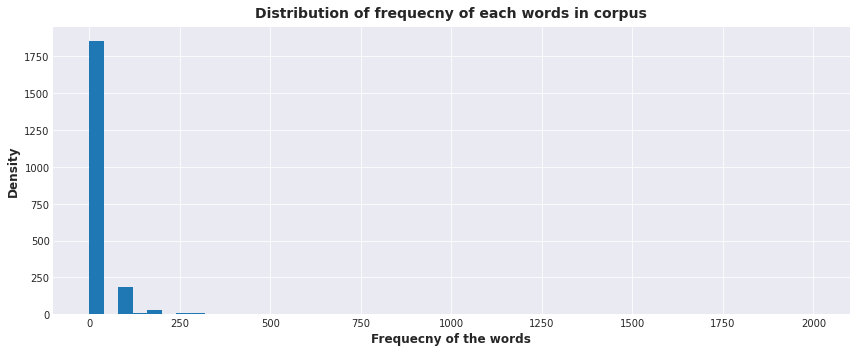

In [16]:
# plot the distribution of words count
plt.figure(figsize=(12,5))
plt.hist(feature_counts.Counts, bins=50, range= (0,2000))
plt.xlabel("Frequecny of the words")
plt.ylabel("Density")
plt.title("Distribution of frequecny of each words in corpus")
plt.show()

In [17]:
# find the rare words, words that are appear only 1 time
len(feature_counts[feature_counts.Counts == 1])

1228

**Insight:** 

**Out of total 2132 words/features 1228 appears only 1 time, we can remove non-significant words**

### Remove-Stop Words

In [18]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(['harry','potter','code','vinci','da','harry','mountain',
                                              'movie','movies'])
my_stop_words1 = list(my_stop_words)

In [19]:
# setting stop-wrod list in countvectorizer
count_vectorizer1 = CountVectorizer(stop_words = my_stop_words1,
                                   max_features = 1000)    #keeping only 1000 top words
feature_vector1 = count_vectorizer1.fit(train_ds.text)
train_ds_features1 = count_vectorizer1.transform(train_ds.text) 
features = feature_vector1.get_feature_names()
features_counts1 = np.sum(train_ds_features1.toarray(), axis=0)
feature_counts1 = pd.DataFrame(dict(features = features,
                                    counts = features_counts1))
feature_counts1.sort_values('counts', ascending=False)[:15]

,features,counts
73,brokeback,2000
408,love,1624
39,awesome,1127
436,mission,1094
341,impossible,1093
390,like,974
745,sucks,602
743,sucked,600
297,hate,578
652,really,374


### Stemming and lemmatization

**Stemming: It chops-off the words to the stemmed words**

**LemmatizationL It converts the words into its root form (i.e English Dictionary)**

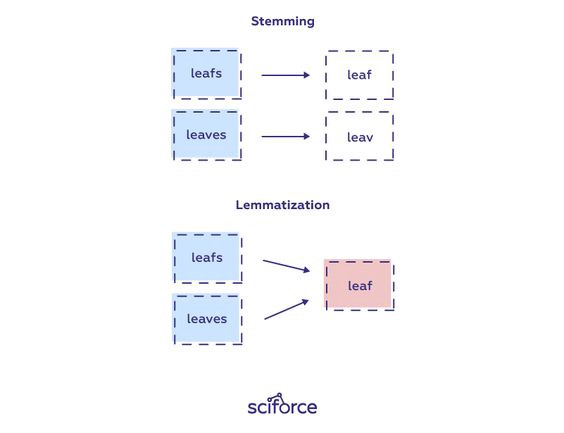

In [20]:
# let's learn what is stemming and lemmatization by example
print("Original:")
print(train_ds.text[1])
print()

sentence = []
for word in train_ds.text[1].split():
    stemmer = PorterStemmer()
    sentence.append(stemmer.stem(word))
print("Stemming:")
print(' '.join(sentence))
print()

sentence = []
for word in train_ds.text[1].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word))
print("Lemmatizing")
print(' '.join(sentence))
print()

Original:
this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this.

Stemming:
thi wa the first clive cussler i'v ever read, but even book like relic, and Da vinci code were more plausibl than this.

Lemmatizing
this wa the first clive cussler i've ever read, but even book like Relic, and Da Vinci code were more plausible than this.



In [21]:
# text pre-processing with stop-words and stemming
analyzer = CountVectorizer().build_analyzer()
# custom function for stemming and stop word reomval
def stemming_words(doc):
    stemmed_words = [stemmer.stem(w) for w in analyzer(doc)] # stemming the words
    non_stop_words = [word for word in stemmed_words if word not in my_stop_words1] # keep non stop words only
    return non_stop_words

In [22]:
count_vectorizer2 = CountVectorizer(analyzer=stemming_words, max_features=1000)
feature_vector2 = count_vectorizer2.fit(train_ds.text)
train_ds_features2 = count_vectorizer2.transform(train_ds.text) 
features = feature_vector2.get_feature_names()
features_counts2 = np.sum(train_ds_features2.toarray(), axis=0)
feature_counts2 = pd.DataFrame(dict(features = features,
                                    counts = features_counts2))
feature_counts2.sort_values('counts', ascending=False)[:15]

,features,counts
303,harri,2093
83,brokeback,2000
414,love,1883
791,suck,1484
922,wa,1176
400,like,1155
447,movi,1149
45,awesom,1130
441,mission,1094
351,imposs,1093


In [23]:
# Crete final train data frame to build models
trn_ds_df = pd.DataFrame(train_ds_features2.todense()) # convert sparse array to dataframe
trn_ds_df.columns = features  # assign features of train daraframe
trn_ds_df['sentiment'] = train_ds.sentiment
trn_ds_df.head()

,10,17,33,6th,aaron,abl,absolut,absurd,academi,accept,...,year,yesterday,yip,young,younger,yuck,yuh,zach,zen,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
trn_ds_df.shape

(6918, 1001)

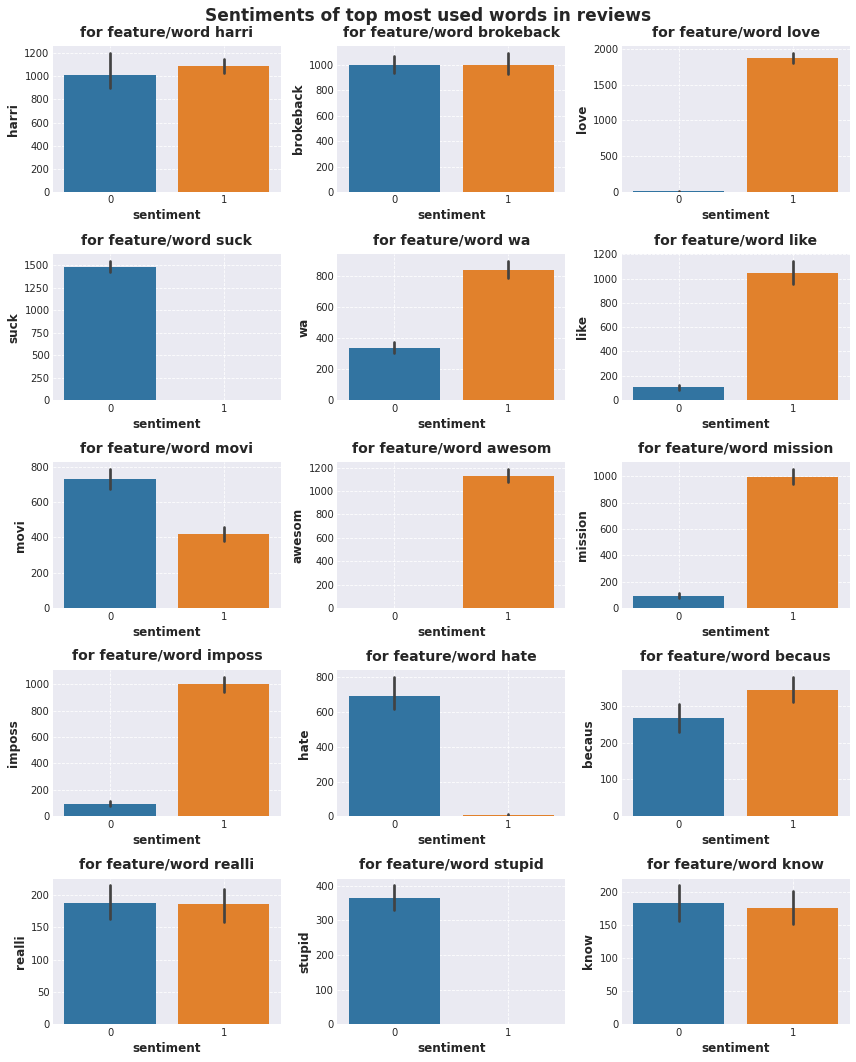

In [25]:
bar_df = feature_counts2.sort_values('counts', ascending=False)[:15]
feature_list = list(bar_df.features)

fig, ax = plt.subplots(5,3, figsize=(12,15))
for i, j in enumerate(feature_list):
    sns.barplot(x='sentiment', y=j ,data=trn_ds_df, estimator=sum, ax=ax[i//3, i%3])
    ax[i//3, i%3].grid(visible=True, linestyle='--')
    ax[i//3, i%3].set_title(f'for feature/word {j}')
    
plt.suptitle("Sentiments of top most used words in reviews", fontsize=17, fontweight='bold')
plt.show()

**Insight:** 

**We can see word/feature appreance and its sentiment mostly negative words like 'hate', 'stupid' are having (0) negative sentiment and positive words 'love', 'like' are having positive sentiment.**

a**lso by keeping most used words which most likely to map target variable will improve sentiment classification accuracy.**

### Wordcloud of reviews

(-0.5, 1599.5, 599.5, -0.5)

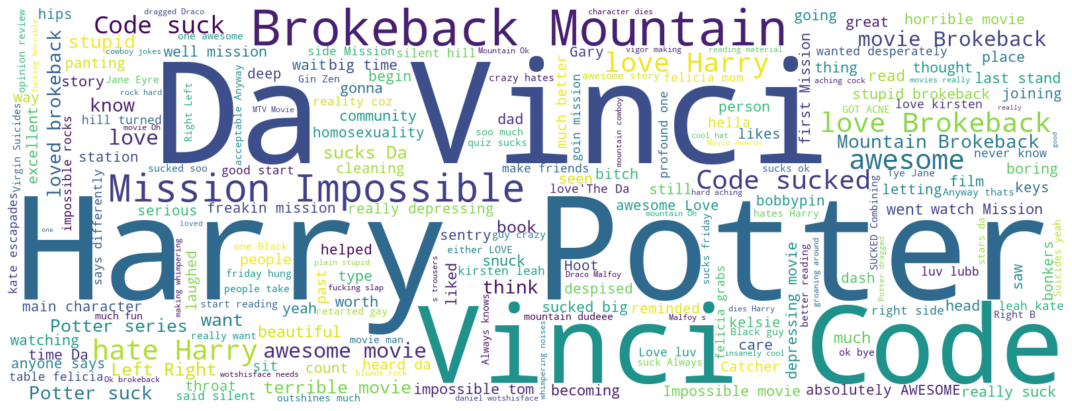

In [26]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='white',
               stopwords=STOPWORDS).generate(' '.join(train_ds.text))

plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

### Naive-Bayes model for sentiment classification

In [27]:
train_X,test_X,train_y,test_y = train_test_split(train_ds_features2, train_ds.sentiment,
                                                   test_size = 0.3, random_state=42)
print(train_X.shape) 
print(test_X.shape)

# naive-bayes classifier
nb_clf = BernoulliNB()
nb_clf.fit(train_X.toarray(), train_y)
prediction = nb_clf.predict(test_X.toarray())

(4842, 1000)
(2076, 1000)


In [28]:
# classification report of test out output and prediction
classificationreport = classification_report(test_y, prediction)
print(classificationreport)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       873
           1       0.98      0.99      0.98      1203

    accuracy                           0.98      2076
   macro avg       0.98      0.98      0.98      2076
weighted avg       0.98      0.98      0.98      2076



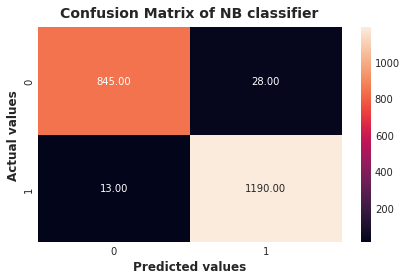

In [29]:
# plot the confusion matrix
cm = confusion_matrix(test_y, prediction)
sns.heatmap(cm, annot=True, fmt=".2f")
plt.title("Confusion Matrix of NB classifier")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

**Observation:**

**Naive-Bayes model gives you an accuracy of 98% for sentiment classification model.**

# 2. Using TF-IDF vectorizer

In [30]:
trn_X,tst_X,trn_y,tst_y = train_test_split(train_ds.text, train_ds.sentiment,
                                                   test_size = 0.3, random_state=42)

# transform dataset into cleaned vectorizors 
tfidf_vectorizer = TfidfVectorizer(analyzer= stemming_words,
                                   max_features = 1000)
feature_train = tfidf_vectorizer.fit_transform(trn_X)
feature_test = tfidf_vectorizer.transform(tst_X)

In [31]:
# models to be trained 
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [32]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, feature_train, trn_y, scoring='accuracy', 
                                cv= StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [33]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

accuracy_df = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
accuracy_df

,Model,Accuracy
0,DecisionTreeClassifier,0.991740
1,RandomForestClassifier,0.993805
2,LogisticRegression,0.993805
3,KNeighborsClassifier,0.980175
4,BernoulliNB,0.988022


**Logistic Regression is best performer for our dataset so will build loistic regression model for sentiment classification.**

In [34]:
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(feature_train, trn_y)
prediction_log = logistic_reg.predict(feature_test)
clf_report = classification_report(tst_y, prediction_log)
print(clf_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       873
           1       0.98      0.99      0.99      1203

    accuracy                           0.99      2076
   macro avg       0.99      0.98      0.99      2076
weighted avg       0.99      0.99      0.99      2076



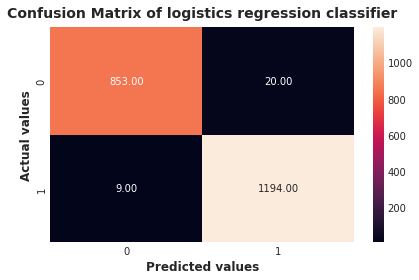

In [35]:
# plot the confusion matrix
cm_log = confusion_matrix(tst_y, prediction_log)
sns.heatmap(cm_log, annot=True, fmt=".2f")
plt.title("Confusion Matrix of logistics regression classifier")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

**Observation:** 

**With logistic regression we got around 99% accuracy which is more than Naive-Bayes classifier apparently.**

# 3. Using n-Grams range with TF-IDF vectorizor

In [36]:
# define get_stemmed_tokens for n-grams
def get_stemmed_tokens(doc):
    all_tokens = [word for word in nltk.word_tokenize(doc)]
    clean_tokens = []
    for each_token in all_tokens:
        if re.search('[a-zA-Z]', each_token):
            clean_tokens.append(each_token)
    # stem the words
    stemmed_tokens = [stemmer.stem(t) for t in clean_tokens]
    return stemmed_tokens

In [37]:
tfidf_vector = TfidfVectorizer(max_features=1000,
                               stop_words='english',
                               tokenizer = get_stemmed_tokens,
                               ngram_range=(1,2))

feature_trn = tfidf_vector.fit_transform(trn_X)
feature_tst = tfidf_vector.transform(tst_X)
# build Naive-bayes model
NB_model = BernoulliNB()
NB_model.fit(feature_trn, trn_y)
preds = NB_model.predict(feature_tst)
clf_report = classification_report(tst_y, preds)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       873
           1       0.96      1.00      0.98      1203

    accuracy                           0.98      2076
   macro avg       0.98      0.97      0.98      2076
weighted avg       0.98      0.98      0.98      2076



**Observation:**

**Using n-Grams range of (1,2) we received 98% accuracy of sentiment classification using Naive-Bayes model.**

# Conclusion:

**1. We build 5 different models using Count vectorization and TF-IDF vectorization techniques to extract features from text data**

**2. We used stop-words removal, stemming and regular expressions for text data cleaning**

**3. With Logistic regression model we recieved highest accuracy of 99% and with Naive-Bayes model we recieved accuracy of 98%.** 